In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
api = KaggleApi()
api.authenticate()

In [ ]:
api.competition_download_file(
    "sentiment-analysis-on-movie-reviews", "train.tsv.zip", path="./"
)

In [ ]:
import zipfile

with zipfile.ZipFile("train.tsv.zip", "r") as zipref:
    zipref.extractall("./")

In [ ]:
import sys

print(sys.path)

In [ ]:
sys.path.append(
    "./venv/lib/python3.9/site-packages/"
)

In [127]:
!pip install nb-black

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [213]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
import tensorflow as tf
from math import ceil
from transformers import AutoTokenizer, TFAutoModel, BertTokenizer
from scipy.special import softmax

In [95]:
df = pd.read_csv("train.tsv", sep="\t")

In [96]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [97]:
df.drop_duplicates(subset="SentenceId", keep="first", inplace=True, ignore_index=True)
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,64,2,"This quiet , introspective and entertaining in...",4
2,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
3,117,4,A positively thrilling combination of ethnogra...,3
4,157,5,Aggressive self-glorification and a manipulati...,1


In [98]:
len(df)

8529

In [99]:
seqlen = df["Phrase"].apply(lambda x: len(x.split()))

In [8]:
sns.set_style("darkgrid")
plt.figure(figsize=(16, 10))
sns.histplot(seqlen)

NameError: name 'sns' is not defined

#### Encode Data

In [113]:
SEQ_LEN = 32

In [114]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [120]:
tokens = tokenizer.encode_plus(
    "hello world",
    max_length=SEQ_LEN,
    truncation=True,
    padding="max_length",
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=True,
    return_tensors="tf",
)

In [121]:
tokens

{'input_ids': <tf.Tensor: shape=(1, 32), dtype=int32, numpy=
array([[  101, 19082,  1362,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 32), dtype=int32, numpy=
array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>}

In [125]:
tokens = tokenizer.batch_encode_plus(
    df["Phrase"].to_list(),
    max_length=SEQ_LEN,
    truncation=True,
    padding="max_length",
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=True,
    return_tensors="tf",
)

In [126]:
Xids, Xmask = tokens["input_ids"], tokens["attention_mask"]

In [127]:
Xids

<tf.Tensor: shape=(8529, 32), dtype=int32, numpy=
array([[ 101,  138, 1326, ..., 5411, 1821,  102],
       [ 101, 1188, 3589, ...,    0,    0,    0],
       [ 101, 2431, 3899, ...,    0,    0,    0],
       ...,
       [ 101,  118,  149, ...,    0,    0,    0],
       [ 101, 1109, 2523, ...,    0,    0,    0],
       [ 101, 1109, 1273, ..., 2897,  119,  102]], dtype=int32)>

In [128]:
Xmask

<tf.Tensor: shape=(8529, 32), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>

In [129]:
sentiment_arr

array([1, 4, 1, ..., 1, 1, 2])

In [130]:
sentiment_arr = df["Sentiment"].values

labels = np.zeros((sentiment_arr.size, sentiment_arr.max() + 1), dtype=int)

# replacing 0 with a 1 at the index of the original array
labels[np.arange(sentiment_arr.size), sentiment_arr] = 1

In [131]:
labels

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [132]:
labels_tf = tf.convert_to_tensor(labels, dtype="int32")
labels_tf

<tf.Tensor: shape=(8529, 5), dtype=int32, numpy=
array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=int32)>

In [133]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels_tf))

In [134]:
dataset

<TensorSliceDataset shapes: ((32,), (32,), (5,)), types: (tf.int32, tf.int32, tf.int32)>

In [135]:
for i in dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([  101,   138,  1326,  1104, 13936, 25265, 16913, 15107,  1103,
        8050,  2553,  1115,  1184,  1110,  1363,  1111,  1103, 20398,
        1110,  1145,  1363,  1111,  1103,   176,  9900,   117,  1199,
        1104,  1134,  5411,  1821,   102], dtype=int32)>, <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>, <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 1, 0, 0, 0], dtype=int32)>)


TensorFlow expects input data as Dataset to be in tuple format. Where 0 index is input values and 1 is labels. We are using 2 inputs so within input we need to have a dictionary.

In [136]:
def map_func(input_ids, masks, labels):
    return {"input_ids": input_ids, "attention_mask": masks}, labels

In [137]:
dataset = dataset.map(map_func)

In [138]:
for i in dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([  101,   138,  1326,  1104, 13936, 25265, 16913, 15107,  1103,
        8050,  2553,  1115,  1184,  1110,  1363,  1111,  1103, 20398,
        1110,  1145,  1363,  1111,  1103,   176,  9900,   117,  1199,
        1104,  1134,  5411,  1821,   102], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>}, <tf.Tensor: shape=(5,), dtype=int32, numpy=array([0, 1, 0, 0, 0], dtype=int32)>)


In [139]:
BATCH_SIZE = 32

In [140]:
dataset = dataset.shuffle(100_000).batch(BATCH_SIZE) #.repeat()

In [151]:
for i in dataset.take(1):
    print(i)

({'input_ids': <tf.Tensor: shape=(32, 32), dtype=int32, numpy=
array([[  101,  1249,  5805, ...,     0,     0,     0],
       [  101, 12515,   165, ..., 15538,  1105,   102],
       [  101, 12515,   118, ...,  2302,  3404,   102],
       ...,
       [  101,  1135, 12246, ...,     0,     0,     0],
       [  101,  1135,   112, ...,  2332,  5986,   102],
       [  101, 13719,  6758, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(32, 32), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}, <tf.Tensor: shape=(32, 5), dtype=int32, numpy=
array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],

In [149]:
DS_LEN = dataset.cardinality().numpy()
DS_LEN = len([0 for batch in dataset])
DS_LEN

267

In [150]:
NO_BATCHES = ceil(DS_LEN / BATCH_SIZE)
NO_BATCHES

9

In [153]:
SPLIT = 0.9

train = dataset.take(round(DS_LEN * SPLIT))  #.repeat(EPOCHS * STEPS_PER_EPOCH)
val = dataset.skip(round(DS_LEN * SPLIT))

In [154]:
train

<TakeDataset shapes: ({input_ids: (None, 32), attention_mask: (None, 32)}, (None, 5)), types: ({input_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [155]:
bert = TFAutoModel.from_pretrained("bert-base-cased")

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


#### Build Model

Define the input layers

In [156]:
# Attention, name needs to be the same as in previously defined dict
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name="input_ids", dtype="int32")
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name="attention_mask", dtype="int32")

#input_ids = tf.keras.layers.Reshape([-1])(input_ids)
#mask = tf.keras.layers.Reshape([-1])(mask)

Bert takes in two inputs and returns 3 outputs from last layer of Bert model. The second tensor is the pooler output (last hidden state ran over activation function and then pooled - can be used directly for classification) which we're going to ignore.

In [175]:
embeddings = bert(input_ids, attention_mask=mask)[0]

# Original Author: Ferry Djaja
# https://djajafer.medium.com/multi-class-text-classification-with-keras-and-lstm-4c5525bef592
X = tf.keras.layers.Dropout(0.1)(embeddings)
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(768))(X)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids,mask], outputs=y)

In [176]:
model.layers[2].trainable = False

In [177]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 32)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 32)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_120 (Dropout)           (None, 32, 768)      0           tf_bert_model_2[4][0]      

In [178]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy("accuracy")

In [179]:
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [180]:
EPOCHS = 10
STEPS_PER_EPOCH = 4

In [181]:
history = model.fit(train, validation_data=val, epochs=EPOCHS, validation_freq=5)  #, steps_per_epoch=STEPS_PER_EPOCH

Epoch 1/10


2023-01-01 17:19:22.573817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-01 17:19:25.571842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-01 17:19:25.580338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-01 17:19:26.122979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-01 17:19:26.135005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


240/240 [==============================] - 172s 688ms/step - loss: 1.3463 - accuracy: 0.4154
Epoch 2/10
240/240 [==============================] - 163s 679ms/step - loss: 1.2116 - accuracy: 0.4799
Epoch 3/10
240/240 [==============================] - 164s 682ms/step - loss: 1.1617 - accuracy: 0.5040
Epoch 4/10
240/240 [==============================] - 165s 686ms/step - loss: 1.0886 - accuracy: 0.5368
Epoch 5/10
240/240 [==============================] - 173s 721ms/step - loss: 1.0202 - accuracy: 0.5655
Epoch 6/10
240/240 [==============================] - 169s 705ms/step - loss: 0.9132 - accuracy: 0.6164
Epoch 7/10
240/240 [==============================] - 173s 722ms/step - loss: 0.7692 - accuracy: 0.6876
Epoch 8/10
240/240 [==============================] - 167s 696ms/step - loss: 0.6195 - accuracy: 0.7579
Epoch 9/10
240/240 [==============================] - 168s 698ms/step - loss: 0.4720 - accuracy: 0.8220
Epoch 10/10
240/240 [==============================] - 170s 710ms/step - lo

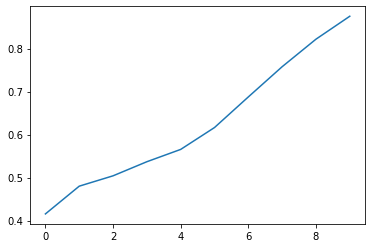

In [189]:
plt.plot(history.history['accuracy'])

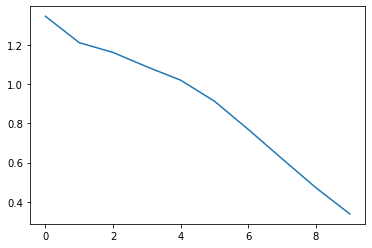

In [190]:
plt.plot(history.history['loss'])

#### Making predictions 

In [183]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [192]:
def prep_data(text):
    tokens = tokenizer.encode_plus(
    text,
    max_length=SEQ_LEN,
    truncation=True,
    padding="max_length",
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=True,
    return_tensors="tf",
)
    return {
        "input_ids": tf.cast(tokens["input_ids"], tf.int32),
        "attention_mask": tf.cast(tokens["attention_mask"], tf.int32)
    }

In [207]:
sentiment = {0: "negative",
1: "somewhat negative",
2: "neutral",
3: "somewhat positive",
4: "positive"}

In [256]:
review = """Not sure if I'm watching the same movie as like other high rating viewers! The story is so flat and so so slow. I look forward to any special or mysterious elements but it ends up nothing coming up. I love Tang Wei and understand her extra effort in speaking Korean but it can't save the movie!"""

In [257]:
test_data = prep_data(review)

probs = model.predict(test_data)

In [258]:
probs[np.where(probs==np.max(probs))] = 1

pred = np.where(probs > 0.5, 1, 0)

In [259]:
prediction = np.nonzero(pred)[1][0]

print(f"This is a *{sentiment[prediction]}* review")

This is a *somewhat negative* review
